# (16) Simulation -- wrong

**Motivation**: Simulate optical flow patterns due to self-motion. <br>

In [1]:
# HIDE CODE


import os
import sys
from copy import deepcopy as dc
from os.path import join as pjoin
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-MTMST/_extras')
fig_base_dir = pjoin(git_dir, 'jb-MTMST/figs')
tmp_dir = pjoin(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_MTMST'))
from analysis.opticflow import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


from skimage.transform import resize


def _alpha_dot(x, x0, xs, v, z, vz):
    a = (x - x0)
    b = (x + x0 - 2 * xs)
    c = (x - xs) * (x0 - xs)
    numin = (c - z**2) * vz + z * b * v
    denum = (c + z**2) ** 2 + (z * a) ** 2
    return a * numin / denum


def _alpha(x, x0, xs, z):
    a = (x - x0)
    c = (x - xs) * (x0 - xs)
    alpha = (z * a) / (z**2 + c)
    return np.arctan(abs(alpha)) * np.sign(alpha)


def compute_angular_velocity_tmp(
    x,
    y,
    pos_self: np.ndarray,
    vel_self: np.ndarray,
    fix: Tuple[float, float], ):
    
    alpha_dot_x = _alpha_dot(x, fix[0], pos_self[0], vel_self[0], pos_self[2], vel_self[2])
    alpha_dot_y = _alpha_dot(y, fix[1], pos_self[1], vel_self[1], pos_self[2], vel_self[2])
    
    alpha_x = _alpha(x, fix[0], pos_self[0], pos_self[2])
    alpha_y = _alpha(y, fix[1], pos_self[1], pos_self[2])
    
    rho = np.sqrt(alpha_x**2 + alpha_y**2)
    phi = np.arctan2(alpha_y, alpha_x)
    if phi < 0:
        phi += 2 * np.pi

    rho_dot = alpha_dot_x * np.cos(phi) + alpha_dot_y * np.sin(phi)
    if rho == 0:
        phi_dot = 0
    else:
        phi_dot = (- alpha_dot_x * np.sin(phi) + alpha_dot_y * np.cos(phi)) / rho

    output = {
        'alpha_dot_x': alpha_dot_x,
        'alpha_dot_y': alpha_dot_y,
        'alpha_x': alpha_x,
        'alpha_y': alpha_y,
        'rho_dot': rho_dot,
        'phi_dot': phi_dot,
        'rho': rho,
        'phi': phi,
    }
    return output


def compute_angular_velocity(
    xy: np.ndarray,
    pos_self: np.ndarray,
    vel_self: np.ndarray,
    fix: Tuple[float, float], ):

    raise NotImplementedError


def _show1(absolute=False, apply_fov=False, figsize=(9.5, 3.9)):
    fig, axes = create_figure(2, 4, figsize, 'all', 'all', tight_layout=True)

    x2p = np.abs(alpha_dot[..., 0]) if absolute else alpha_dot[..., 0]
    im = axes[0, 0].imshow(x2p[yr][:, xr] if apply_fov else x2p)
    axes[0, 0].set_title(r'$\dot{\alpha}_x$', fontsize=20)
    plt.colorbar(im, ax=axes[0, 0])

    x2p = np.abs(alpha_dot[..., 1]) if absolute else alpha_dot[..., 1]
    im = axes[0, 1].imshow(x2p[yr][:, xr] if apply_fov else x2p)
    axes[0, 1].set_title(r'$\dot{\alpha}_y$', fontsize=20)
    plt.colorbar(im, ax=axes[0, 1])

    x2p = np.abs(rho_dot) if absolute else rho_dot
    im = axes[0, 2].imshow(x2p[yr][:, xr] if apply_fov else x2p)
    axes[0, 2].set_title(r'$\dot{\rho}$', fontsize=20)
    plt.colorbar(im, ax=axes[0, 2])

    x2p = np.abs(phi_dot) if absolute else phi_dot
    im = axes[0, 3].imshow(x2p[yr][:, xr] if apply_fov else x2p)
    axes[0, 3].set_title(r'$\dot{\phi}$', fontsize=20)
    plt.colorbar(im, ax=axes[0, 3])

    x2p = np.abs(alpha[..., 0]) if absolute else alpha[..., 0]
    im = axes[1, 0].imshow(x2p[yr][:, xr] if apply_fov else x2p)
    axes[1, 0].set_title(r'$\alpha_x$', fontsize=20)
    plt.colorbar(im, ax=axes[1, 0])

    x2p = np.abs(alpha[..., 1]) if absolute else alpha[..., 1]
    im = axes[1, 1].imshow(x2p[yr][:, xr] if apply_fov else x2p)
    axes[1, 1].set_title(r'$\alpha_y$', fontsize=20)
    plt.colorbar(im, ax=axes[1, 1])

    x2p = np.abs(rho) if absolute else rho
    im = axes[1, 2].imshow(x2p[yr][:, xr] if apply_fov else x2p)
    axes[1, 2].set_title(r'$\rho$', fontsize=20)
    plt.colorbar(im, ax=axes[1, 2])

    x2p = np.abs(phi) if absolute else phi
    im = axes[1, 3].imshow(x2p[yr][:, xr] if apply_fov else x2p)
    axes[1, 3].set_title(r'$\phi$', fontsize=20)
    plt.colorbar(im, ax=axes[1, 3])

    axes.flat[-1].invert_yaxis()
    plt.show()
    
    
def fov_coords(num: int, fix: Tuple[float, float]):
    w = num - abs(max(fix, key=abs))
    xr = range(num+fix[0]-w, num+fix[0]+w+1)
    yr = range(num+fix[1]-w, num+fix[1]+w+1)
    return xr, yr, w

## Setup

Imagine an observer that is moving in a $3D$ space, while maintaining fixation. There is a solid background at the $z=0$ plane, and the fixation point is situated somewhere on this plane. The goal is to compute optical flow patterns perceived by this observer. Here is the setup:

- $\vec{F} = (x_0, y_0, 0)$, the fixation point.
- $\vec{P} = (x, y, 0)$, a given point on the background plane.
- $\vec{O} = (x_s, y_s, z_s)$, poistion of the observer ($s$ stands for *self*).
- $\vec{v} = (v_x, v_y, v_z)$, the observer's $3D$ self-motion velocity vector.

For simplicity we use $z \equiv z_s$, therefore $\vec{O} = (x_s, y_s, z)$. The relationship between background points observer's FOV is given by

\begin{equation}
\tan\alpha_x = \tan(\rho \cos\phi) = \frac{z(x - x_0)}{z^2 + (x - x_s)(x_0 - x_s)},
\end{equation}
\begin{equation}
\tan\alpha_y = \tan(\rho \sin\phi) = \frac{z(y - y_0)}{z^2 + (y - y_s)(y_0 - y_s)},
\end{equation}

where $\alpha_x = \rho \cos\phi$ and $\alpha_y = \rho \sin\phi$ are the $x$ and $y$ components of point $\vec{P}$ projected onto the observers FOV ($\alpha_x$ and $\alpha_y$ are measured in radians). See below for an illustration of the setup:

---

<img src="../../_extras/Self-motion.png" title="Simulation setup" alt="null" width="500" class="center"/>

---

Differentiate the equations to get

\begin{equation}
(1 + \tan^2\alpha_x) \dot{\alpha}_x = (x - x_0) \frac{\big[(x - x_s)(x_0 - x_s) - z^2\big] v_z + z(x + x_0 - 2x_s)v_x}{\big[z^2 + (x - x_s)(x_0 - x_s)\big]^2},
\end{equation}
\begin{equation}
(1 + \tan^2\alpha_y) \dot{\alpha}_y = (y - y_0) \frac{\big[(y - y_s)(y_0 - y_s) - z^2\big] v_z + z(y + y_0 - 2y_s) v_y}{\big[z^2 + (y - y_s)(y_0 - y_s)\big]^2},
\end{equation}

where $\vec{v} = (v_x, v_y, v_z)$ is the observer's $3D$ self-motion velocity vector. Simplifying these euqtions yields

\begin{equation}
\boxed{
\dot{\alpha}_x = (x - x_0) \frac{\big[(x - x_s)(x_0 - x_s) - z^2\big] v_z + z(x + x_0 - 2x_s)v_x}{\big[z^2 + (x - x_s)(x_0 - x_s)\big]^2 + z^2(x - x_0)^2}
}
\end{equation}
\begin{equation}
\boxed{
\dot{\alpha}_y = (y - y_0) \frac{\big[(y - y_s)(y_0 - y_s) - z^2\big] v_z + z(y + y_0 - 2y_s) v_y}{\big[z^2 + (y - y_s)(y_0 - y_s)\big]^2 + z^2(y - y_0)^2}
}
\end{equation}

Thus, we obtained angular velocity of a background point $\dot{\vec{\alpha}} = (\dot{\alpha}_x, \dot{\alpha}_y)$ as a function of self-motion $\vec{v}$. Note that the velocity at the fixation point is always zero because $x = x_0$ and $y = y_0$ implies $\dot{\vec{\alpha}} = \vec{0}$ (as expected). Finally, the polar velocity components $\dot{\rho}$ and $\dot{\phi}$ can be obtained from $\dot{\vec{\alpha}}$ as follows

\begin{equation}
\dot{\rho} = \dot{\alpha}_x \cos\phi + \dot{\alpha}_y \sin\phi,\\
\rho\dot{\phi} = - \dot{\alpha}_x \sin\phi + \dot{\alpha}_y \cos\phi.
\end{equation}

Let us now consider some special cases below.

## Example 1

A simple case where the observer is moving towards the background while fixating at the center.  In other words:
```python
pos_self = (0, 0, 10)
vel_self = (0, 0, -1)
fix = (0, 0)
```

In [3]:
# HIDE CODE


num = 50
width = 2 * num + 1
span = np.linspace(-num, num, width)

pos_self = (0, 0, 10)
vel_self = (0, 0, -1)
fix = (0, 0)
xr, yr, w = fov_coords(num, fix)

alpha_dot = np_nans((width, width, 2))
alpha = np_nans((width, width, 2))
rho_dot = np_nans((width, width))
phi_dot = np_nans((width, width))
rho = np_nans((width, width))
phi = np_nans((width, width))

for i, x in enumerate(span):
    for j, y in enumerate(span):
        output = compute_angular_velocity_tmp(
            x=x,
            y=y,
            pos_self=pos_self,
            vel_self=vel_self,
            fix=fix,
        )
        alpha_dot[j, i, 0] = output['alpha_dot_x']
        alpha_dot[j, i, 1] = output['alpha_dot_y']
        alpha[j, i, 0] = output['alpha_x']
        alpha[j, i, 1] = output['alpha_y']
        rho_dot[j, i] = output['rho_dot']
        phi_dot[j, i] = output['phi_dot']
        rho[j, i] = output['rho']
        phi[j, i] = output['phi']

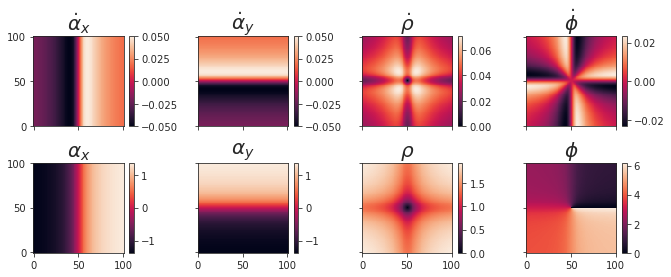

In [4]:
_show1()

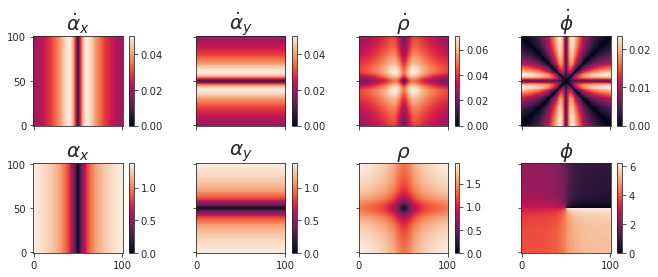

In [5]:
_show1(True)

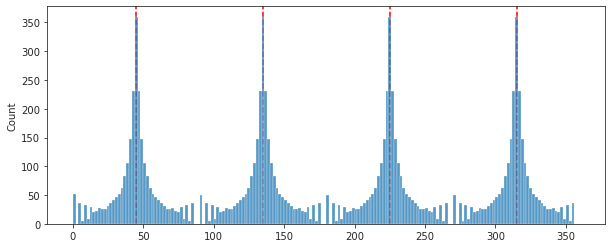

In [6]:
# HIDE CODE


fig, ax = create_figure(figsize=(10, 4))
ax.axvline(45, ls='--', color='r', lw=1.5, zorder=0, alpha=1)
ax.axvline(45 + 90, ls='--', color='r', lw=1.5, zorder=0, alpha=1)
ax.axvline(45 + 180, ls='--', color='r', lw=1.5, zorder=0, alpha=1)
ax.axvline(360 - 45, ls='--', color='r', lw=1.5, zorder=0, alpha=1)
sns.histplot(np.rad2deg(phi.ravel()), bins=np.linspace(0, 360, 181), ax=ax, zorder=2)
plt.show()

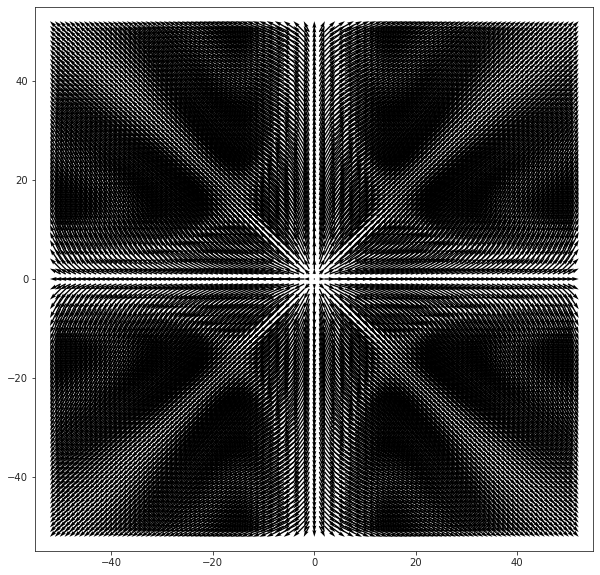

In [7]:
# HIDE CODE


fig, ax = create_figure(figsize=(10, 10))
ax.quiver(
    range(-w, w+1),
    range(-w, w+1),
    alpha_dot[yr][:, xr][..., 0],
    alpha_dot[yr][:, xr][..., 1],
    scale=1,
);

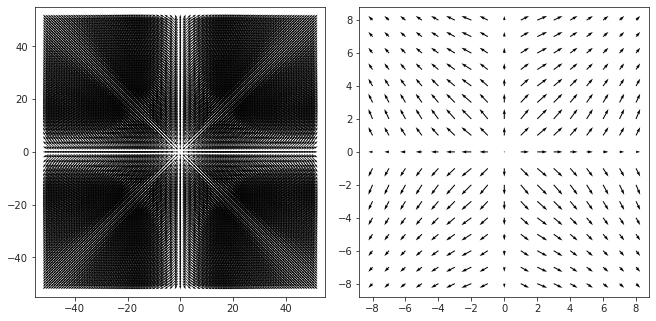

In [8]:
# HIDE CODE


fig, axes = create_figure(1, 2, (9, 4.5), constrained_layout=True)
axes[0].quiver(
    range(-w, w+1),
    range(-w, w+1),
    alpha_dot[yr][:, xr][..., 0],
    alpha_dot[yr][:, xr][..., 1],
    scale=1,
)
axes[1].quiver(
    range(-8, 8 + 1),
    range(-8, 8 + 1),
    resize(alpha_dot[..., 0][yr][:, xr], (16 + 1,) * 2),
    resize(alpha_dot[..., 1][yr][:, xr], (16 + 1,) * 2),
    # scale=2,
)
ax_square(axes)
plt.show()

## Example 2

Similar to above, but instead of moving towad the background, the observer drifts to the side in the $x$ direction. In other words:
```python
pos_self = (0, 0, 10)
vel_self = (1, 0, 0)
fix = (0, 0)
```

In [9]:
# HIDE CODE


num = 50
width = 2 * num + 1
span = np.linspace(-num, num, width)

pos_self = (0, 0, 10)
vel_self = (1, 0, 0)
fix = (0, 0)
xr, yr, w = fov_coords(num, fix)

alpha_dot = np_nans((width, width, 2))
alpha = np_nans((width, width, 2))
rho_dot = np_nans((width, width))
phi_dot = np_nans((width, width))
rho = np_nans((width, width))
phi = np_nans((width, width))

for i, x in enumerate(span):
    for j, y in enumerate(span):
        output = compute_angular_velocity_tmp(
            x=x,
            y=y,
            pos_self=pos_self,
            vel_self=vel_self,
            fix=fix,
        )
        alpha_dot[j, i, 0] = output['alpha_dot_x']
        alpha_dot[j, i, 1] = output['alpha_dot_y']
        alpha[j, i, 0] = output['alpha_x']
        alpha[j, i, 1] = output['alpha_y']
        rho_dot[j, i] = output['rho_dot']
        phi_dot[j, i] = output['phi_dot']
        rho[j, i] = output['rho']
        phi[j, i] = output['phi']

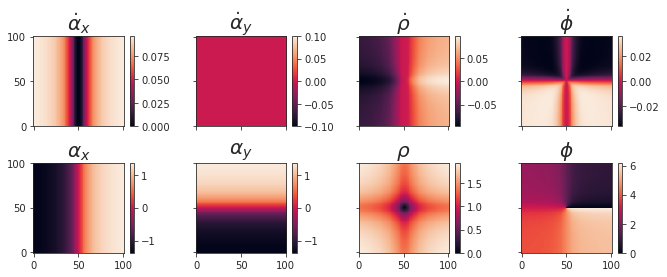

In [10]:
_show1()

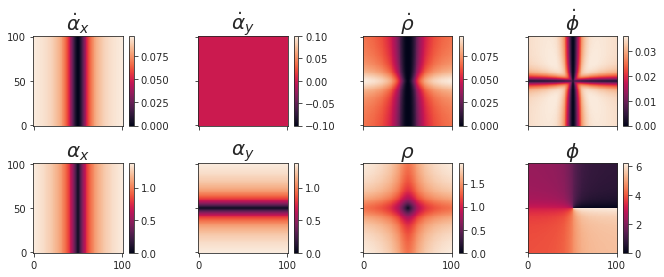

In [11]:
_show1(True)

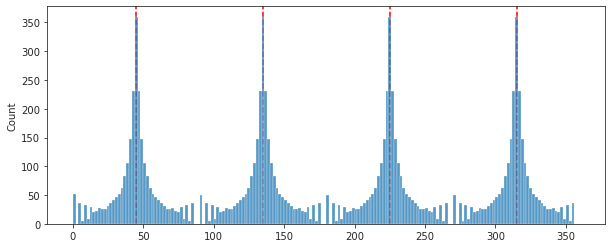

In [12]:
# HIDE CODE


fig, ax = create_figure(figsize=(10, 4))
ax.axvline(45, ls='--', color='r', lw=1.5, zorder=0, alpha=1)
ax.axvline(45 + 90, ls='--', color='r', lw=1.5, zorder=0, alpha=1)
ax.axvline(45 + 180, ls='--', color='r', lw=1.5, zorder=0, alpha=1)
ax.axvline(360 - 45, ls='--', color='r', lw=1.5, zorder=0, alpha=1)
sns.histplot(np.rad2deg(phi.ravel()), bins=np.linspace(0, 360, 181), ax=ax, zorder=2)
plt.show()

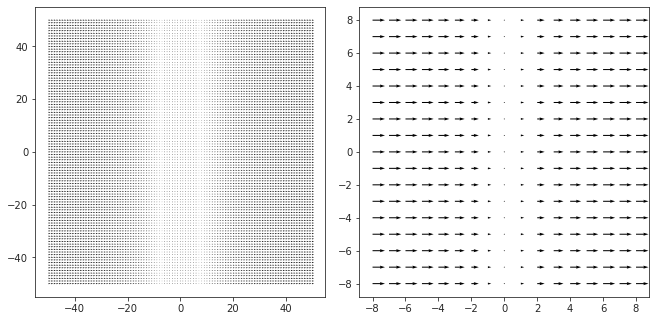

In [13]:
# HIDE CODE


fig, axes = create_figure(1, 2, (9, 4.5), constrained_layout=True)
axes[0].quiver(
    range(-w, w+1),
    range(-w, w+1),
    alpha_dot[yr][:, xr][..., 0],
    alpha_dot[yr][:, xr][..., 1],
    # scale=1,
)
axes[1].quiver(
    range(-8, 8 + 1),
    range(-8, 8 + 1),
    resize(alpha_dot[..., 0][yr][:, xr], (16 + 1,) * 2),
    resize(alpha_dot[..., 1][yr][:, xr], (16 + 1,) * 2),
    # scale=2,
)
ax_square(axes)
plt.show()

## Example 3

Movement in all directions, with equal speeds in $x$ and $y$:
```python
pos_self = (0, 0, 10)
vel_self = (1, 1, -2)
fix = (0, 0)
```

In [14]:
# HIDE CODE


num = 50
width = 2 * num + 1
span = np.linspace(-num, num, width)

pos_self = (0, 0, 10)
vel_self = (1, 1, -2)
fix = (0, 0)
xr, yr, w = fov_coords(num, fix)

alpha_dot = np_nans((width, width, 2))
alpha = np_nans((width, width, 2))
rho_dot = np_nans((width, width))
phi_dot = np_nans((width, width))
rho = np_nans((width, width))
phi = np_nans((width, width))

for i, x in enumerate(span):
    for j, y in enumerate(span):
        output = compute_angular_velocity_tmp(
            x=x,
            y=y,
            pos_self=pos_self,
            vel_self=vel_self,
            fix=fix,
        )
        alpha_dot[j, i, 0] = output['alpha_dot_x']
        alpha_dot[j, i, 1] = output['alpha_dot_y']
        alpha[j, i, 0] = output['alpha_x']
        alpha[j, i, 1] = output['alpha_y']
        rho_dot[j, i] = output['rho_dot']
        phi_dot[j, i] = output['phi_dot']
        rho[j, i] = output['rho']
        phi[j, i] = output['phi']

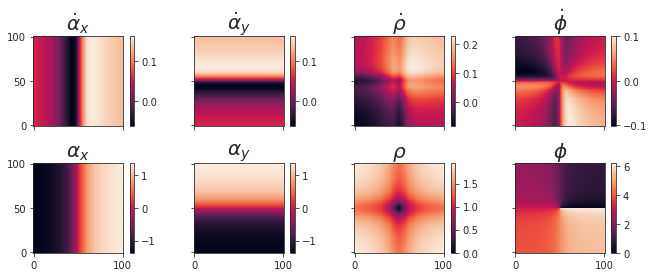

In [15]:
_show1()

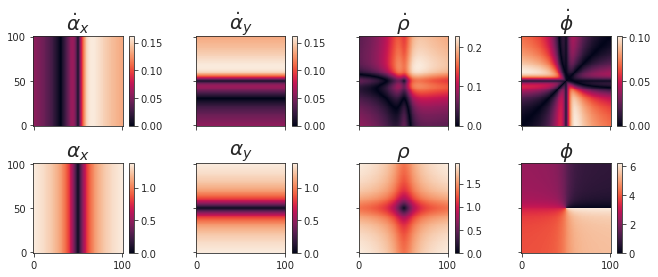

In [16]:
_show1(True)

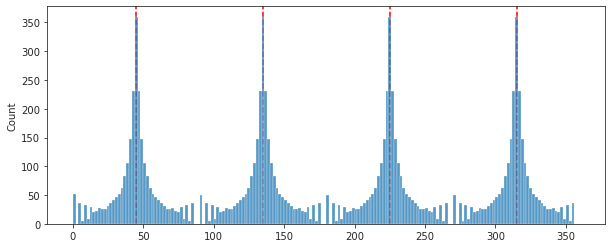

In [17]:
# HIDE CODE


fig, ax = create_figure(figsize=(10, 4))
ax.axvline(45, ls='--', color='r', lw=1.5, zorder=0, alpha=1)
ax.axvline(45 + 90, ls='--', color='r', lw=1.5, zorder=0, alpha=1)
ax.axvline(45 + 180, ls='--', color='r', lw=1.5, zorder=0, alpha=1)
ax.axvline(360 - 45, ls='--', color='r', lw=1.5, zorder=0, alpha=1)
sns.histplot(np.rad2deg(phi.ravel()), bins=np.linspace(0, 360, 181), ax=ax, zorder=2)
plt.show()

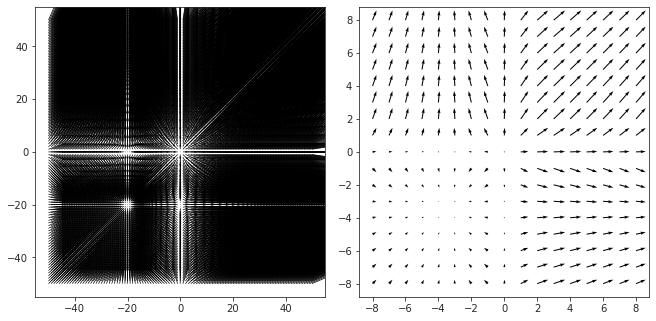

In [18]:
# HIDE CODE


fig, axes = create_figure(1, 2, (9, 4.5), constrained_layout=True)
axes[0].quiver(
    range(-w, w+1),
    range(-w, w+1),
    alpha_dot[yr][:, xr][..., 0],
    alpha_dot[yr][:, xr][..., 1],
    scale=1,
)
axes[1].quiver(
    range(-8, 8 + 1),
    range(-8, 8 + 1),
    resize(alpha_dot[..., 0][yr][:, xr], (16 + 1,) * 2),
    resize(alpha_dot[..., 1][yr][:, xr], (16 + 1,) * 2),
    # scale=2,
)
ax_square(axes)
plt.show()

## Example 4

Going toward the background plane (only $v_z \neq 0$) while fixating on a point other than the center. That is:
```python
pos_self = (0, 0, 50)
vel_self = (0, 0, -1)
fix = (30, 0)
```

In [19]:
# HIDE CODE


num = 60
width = 2 * num + 1
span = np.linspace(-num, num, width)

pos_self = (0, 0, 50)
vel_self = (0, 0, -1)
fix = (30, 0)
xr, yr, w = fov_coords(num, fix)

alpha_dot = np_nans((width, width, 2))
alpha = np_nans((width, width, 2))
rho_dot = np_nans((width, width))
phi_dot = np_nans((width, width))
rho = np_nans((width, width))
phi = np_nans((width, width))

for i, x in enumerate(span):
    for j, y in enumerate(span):
        output = compute_angular_velocity_tmp(
            x=x,
            y=y,
            pos_self=pos_self,
            vel_self=vel_self,
            fix=fix,
        )
        alpha_dot[j, i, 0] = output['alpha_dot_x']
        alpha_dot[j, i, 1] = output['alpha_dot_y']
        alpha[j, i, 0] = output['alpha_x']
        alpha[j, i, 1] = output['alpha_y']
        rho_dot[j, i] = output['rho_dot']
        phi_dot[j, i] = output['phi_dot']
        rho[j, i] = output['rho']
        phi[j, i] = output['phi']

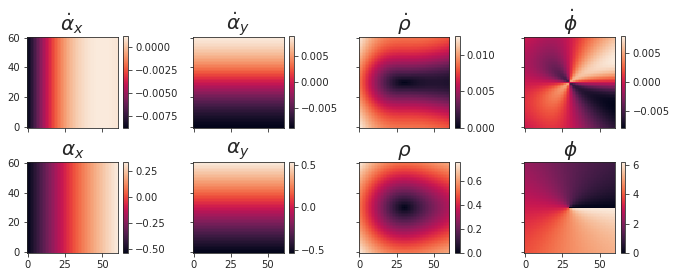

In [20]:
_show1(apply_fov=True)

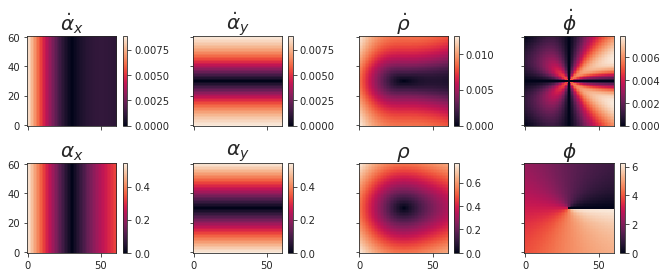

In [21]:
_show1(True, True)

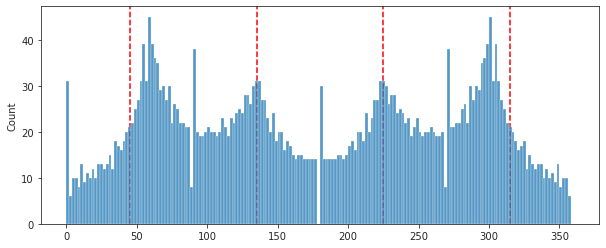

In [22]:
# HIDE CODE


fig, ax = create_figure(figsize=(10, 4))
ax.axvline(45, ls='--', color='r', lw=1.5, zorder=0, alpha=1)
ax.axvline(45 + 90, ls='--', color='r', lw=1.5, zorder=0, alpha=1)
ax.axvline(45 + 180, ls='--', color='r', lw=1.5, zorder=0, alpha=1)
ax.axvline(360 - 45, ls='--', color='r', lw=1.5, zorder=0, alpha=1)
sns.histplot(np.rad2deg(phi[yr][:, xr].ravel()), bins=np.linspace(0, 360, 181), ax=ax, zorder=2)
plt.show()

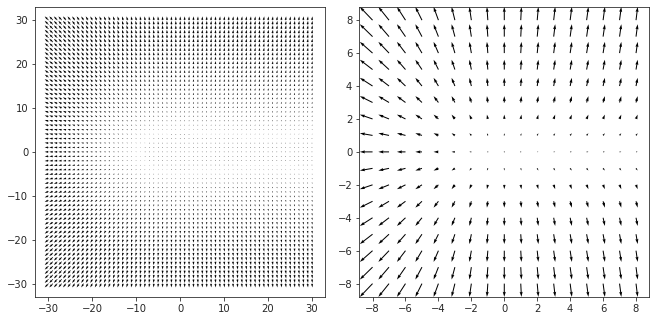

In [23]:
# HIDE CODE


fig, axes = create_figure(1, 2, (9, 4.5), constrained_layout=True)
axes[0].quiver(
    range(-w, w+1),
    range(-w, w+1),
    alpha_dot[yr][:, xr][..., 0],
    alpha_dot[yr][:, xr][..., 1],
    # scale=1,
)
axes[1].quiver(
    range(-8, 8 + 1),
    range(-8, 8 + 1),
    resize(alpha_dot[..., 0][yr][:, xr], (16 + 1,) * 2),
    resize(alpha_dot[..., 1][yr][:, xr], (16 + 1,) * 2),
    # scale=2,
)
ax_square(axes)
plt.show()

## Example 5

Movement in all directions, fixating in a random point and situated in a random point:
```python
pos_self = (10, 5, 50)
vel_self = (-5, 2, -1)
fix = (30, 10)
```

In [24]:
# HIDE CODE


num = 100
width = 2 * num + 1
span = np.linspace(-num, num, width)

pos_self = (10, 5, 50)
vel_self = (-5, 2, -1)
fix = (30, 10)
xr, yr, w = fov_coords(num, fix)

alpha_dot = np_nans((width, width, 2))
alpha = np_nans((width, width, 2))
rho_dot = np_nans((width, width))
phi_dot = np_nans((width, width))
rho = np_nans((width, width))
phi = np_nans((width, width))

for i, x in enumerate(span):
    for j, y in enumerate(span):
        output = compute_angular_velocity_tmp(
            x=x,
            y=y,
            pos_self=pos_self,
            vel_self=vel_self,
            fix=fix,
        )
        alpha_dot[j, i, 0] = output['alpha_dot_x']
        alpha_dot[j, i, 1] = output['alpha_dot_y']
        alpha[j, i, 0] = output['alpha_x']
        alpha[j, i, 1] = output['alpha_y']
        rho_dot[j, i] = output['rho_dot']
        phi_dot[j, i] = output['phi_dot']
        rho[j, i] = output['rho']
        phi[j, i] = output['phi']

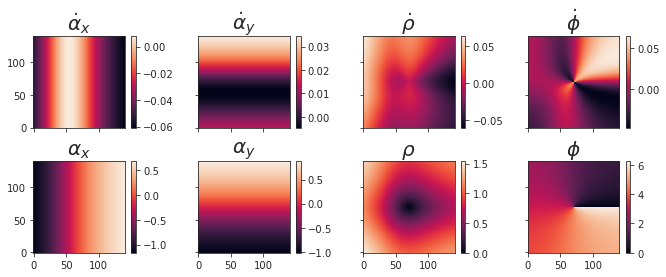

In [25]:
_show1(apply_fov=True)

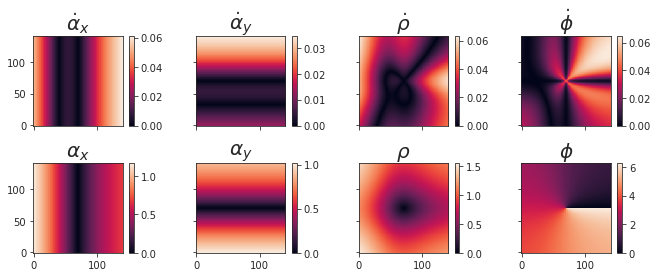

In [26]:
_show1(True, True)

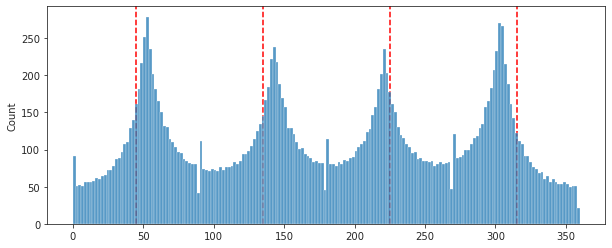

In [27]:
# HIDE CODE


fig, ax = create_figure(figsize=(10, 4))
ax.axvline(45, ls='--', color='r', lw=1.5, zorder=0, alpha=1)
ax.axvline(45 + 90, ls='--', color='r', lw=1.5, zorder=0, alpha=1)
ax.axvline(45 + 180, ls='--', color='r', lw=1.5, zorder=0, alpha=1)
ax.axvline(360 - 45, ls='--', color='r', lw=1.5, zorder=0, alpha=1)
sns.histplot(np.rad2deg(phi[yr][:, xr].ravel()), bins=np.linspace(0, 360, 181), ax=ax, zorder=2)
plt.show()

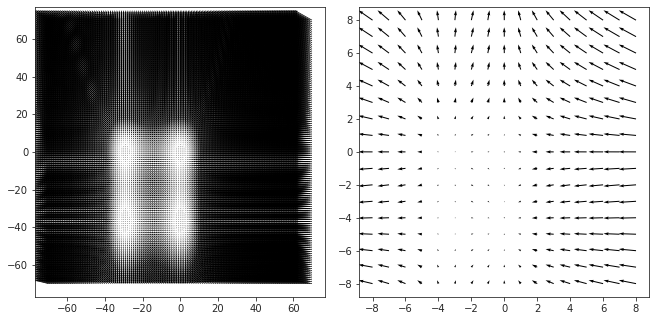

In [28]:
# HIDE CODE


fig, axes = create_figure(1, 2, (9, 4.5), constrained_layout=True)
axes[0].quiver(
    range(-w, w+1),
    range(-w, w+1),
    alpha_dot[yr][:, xr][..., 0],
    alpha_dot[yr][:, xr][..., 1],
    scale=1,
)
axes[1].quiver(
    range(-8, 8 + 1),
    range(-8, 8 + 1),
    resize(alpha_dot[..., 0][yr][:, xr], (16 + 1,) * 2),
    resize(alpha_dot[..., 1][yr][:, xr], (16 + 1,) * 2),
    # scale=2,
)
ax_square(axes)
plt.show()